## Load, enrich, augment and clean the data

In [1]:
# dataset is taken from Kaggle and downloaded from here:
# https://www.kaggle.com/datasets/thomasnibb/amsterdam-house-price-prediction
# license is CC0: Public Domain - can copy, modify, distribute and perform the work, 
# even for commercial purposes, all without asking permission.

import pandas as pd
import numpy as np

pd.set_option('display.float_format', '{:.4f}'.format) # to kill scientific notation..


import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

df = pd.read_csv("HousingPrices-Amsterdam-August-2021.csv")
df.head() # look of the original dataset


,Unnamed: 0,Address,Zip,Price,Area,Room,Lon,Lat
0,1,"Blasiusstraat 8 2, Amsterdam",1091 CR,685000.0000,64,3,4.9077,52.3562
1,2,"Kromme Leimuidenstraat 13 H, Amsterdam",1059 EL,475000.0000,60,3,4.8505,52.3486
2,3,"Zaaiersweg 11 A, Amsterdam",1097 SM,850000.0000,109,4,4.9448,52.3438
3,4,"Tenerifestraat 40, Amsterdam",1060 TH,580000.0000,128,6,4.7899,52.3437
4,5,"Winterjanpad 21, Amsterdam",1036 KN,720000.0000,138,5,4.9025,52.4105


In [2]:
# STEP 1 - make columns look good:
df.columns = df.columns.str.lower()

# We will use only 4 columns for the start
df['pc4'] = df.zip.str.split().str[0]
used_cols = ['pc4', 'area', 'room', 'price']
df = df[used_cols]

df.head(1)

,pc4,area,room,price
0,1091,64,3,685000.0000


In [3]:
df.describe()

,area,room,price
count,924.0000,924.0000,920.0000
mean,95.9524,3.5714,622065.4196
std,57.4474,1.5923,538994.1754
min,21.0000,1.0000,175000.0000
25%,60.7500,3.0000,350000.0000
50%,83.0000,3.0000,467000.0000
75%,113.0000,4.0000,700000.0000
max,623.0000,14.0000,5950000.0000


In [4]:
# STEP 2 -feature engineering skipped, see appendix

# STEP 3 - skipped mappings and focus only on 3 features - pc4, area and rooms
df.pc4.nunique() # 70 - much better for grouping


70

<Axes: xlabel='price', ylabel='Count'>

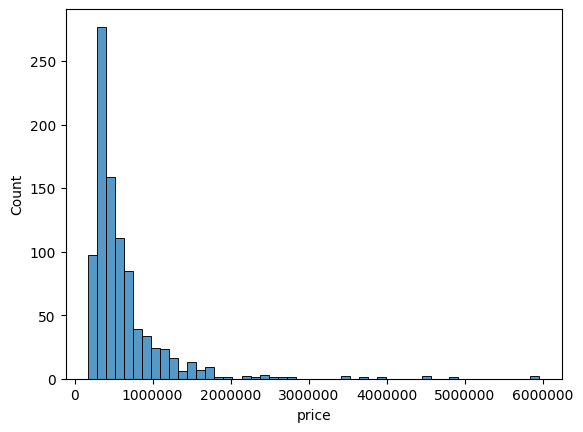

In [5]:
# Look at the price variable. Does it have a long tail - YES!!

plt.ticklabel_format(style='plain')
sns.histplot(df.price, bins=50) 

In [6]:
# missing values and making 
df['area'] = df['area'].astype('int64')
df['room'] = df['room'].astype('int64')

# missing values - count and fill missing values with zeros.
df.isna().sum()

pc4      0
area     0
room     0
price    4
dtype: int64

In [7]:
# As we have only 4 rows with missing price out of 924 we can delete it
df = df.dropna(subset=['price'])
df['price'] = df['price'].astype('int64')
df.describe()


,area,room,price
count,920.0000,920.0000,920.0000
mean,95.6076,3.5641,622065.4196
std,56.8497,1.5710,538994.1754
min,21.0000,1.0000,175000.0000
25%,60.0000,3.0000,350000.0000
50%,83.0000,3.0000,467000.0000
75%,113.0000,4.0000,700000.0000
max,623.0000,14.0000,5950000.0000


In [8]:
# Do train/validation/test split with 60%/20%/20% distribution.
# Use the train_test_split function and set the random_state parameter to 1.

from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [9]:
len(df_full_train), len(df_test) # (736, 184)


(736, 184)

In [10]:
len(df_train), len(df_val)  # (552, 184)

(552, 184)

In [11]:
# reset index in our splits

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [12]:
# now prepare our label (target variable) = fuel_efficiency_mpg
y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values
len(y_train), len(y_val), len(y_test)
# (552, 184, 184)

(552, 184, 184)

In [13]:
# remove our label fuel_efficiency_mpg so model cannot learn from it accidentally

del df_train['price']
del df_val['price']
del df_test['price']

In [14]:
# check all good
# df_test.head()
df_train.pc4.nunique() 
# 69 - our training dataset will be chubby - 552 rows and 71 columns - about 1:8 ratio - danger of overfitting...

69

## Building a Random Forest model

In [15]:
# Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

# we use many categorical features, thus one-hot encoding is needed:
from sklearn.feature_extraction import DictVectorizer

# then we need baked-in SKL metrics so we save time by not hand-coding them:
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

train_dicts = df_train.to_dict(orient='records')
# train_dicts[:5] # quick check - all looks good

In [16]:
# Use DictVectorizer(sparse=True) to turn the dataframes into matrices.
dv = DictVectorizer()   #(sparse=True)
X_train = dv.fit_transform(train_dicts) 
# used DictVectorizer for 1-hot encoding of our training dataset

In [17]:
# CHECK 1:
dv.get_feature_names_out() # after 1-hot encoding how our features look like...
# old version get_feature_names is deprecated, new version is dv.get_feature_names_out()

array(['area', 'pc4=1011', 'pc4=1012', 'pc4=1013', 'pc4=1014', 'pc4=1015',
       'pc4=1016', 'pc4=1017', 'pc4=1018', 'pc4=1019', 'pc4=1021',
       'pc4=1023', 'pc4=1024', 'pc4=1025', 'pc4=1027', 'pc4=1028',
       'pc4=1031', 'pc4=1032', 'pc4=1033', 'pc4=1034', 'pc4=1035',
       'pc4=1036', 'pc4=1051', 'pc4=1052', 'pc4=1053', 'pc4=1054',
       'pc4=1055', 'pc4=1056', 'pc4=1057', 'pc4=1058', 'pc4=1059',
       'pc4=1060', 'pc4=1061', 'pc4=1062', 'pc4=1063', 'pc4=1064',
       'pc4=1065', 'pc4=1066', 'pc4=1067', 'pc4=1068', 'pc4=1069',
       'pc4=1071', 'pc4=1072', 'pc4=1073', 'pc4=1074', 'pc4=1075',
       'pc4=1076', 'pc4=1077', 'pc4=1078', 'pc4=1079', 'pc4=1081',
       'pc4=1082', 'pc4=1083', 'pc4=1086', 'pc4=1087', 'pc4=1091',
       'pc4=1092', 'pc4=1093', 'pc4=1094', 'pc4=1095', 'pc4=1096',
       'pc4=1097', 'pc4=1098', 'pc4=1102', 'pc4=1103', 'pc4=1104',
       'pc4=1106', 'pc4=1107', 'pc4=1108', 'pc4=1109', 'room'],
      dtype=object)

In [18]:
X_train[0]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3 stored elements and shape (1, 71)>

In [27]:
# # CHECK 2 - does not work if sparse = true:
# import numpy as np
# for name, value in zip(dv.get_feature_names_out(), X_train[0]):
#     print(name, value) 
#     # prints our first row nicely using python zip() function - manual check...

In [28]:
# Let's train a decision tree regressor to predict the price variable.

# Train a model with max_depth=1.
# Which feature is used for splitting the data -> area


# we are building a regressor model - to predict price:
from sklearn.tree import DecisionTreeRegressor

# train the decision tree with max_depth=1.

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train) # NB - max_depth 1

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [29]:
# now how to find which feature is used for splitting the data -
from sklearn.tree import export_text
# and get weight coefficients for our decisions
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- area <= 137.50
|   |--- value: [481422.80]
|--- area >  137.50
|   |--- value: [1410864.33]



In [30]:
# Train a random forest regressor with these parameters:

# n_estimators=10
# random_state=1
# n_jobs=-1 (optional - to make training faster)
# What's the RMSE of this model on the validation data - 

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=10,
    random_state=1,
    n_jobs=-1  
)
rf.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [31]:
# prepare X_val

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = rf.predict(X_val)

# What's the RMSE of random forest regressor model on the validation data?
from sklearn.metrics import mean_squared_error

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE: {rmse:.4f}") # RMSE: 327310.8777

RMSE: 327310.8777


In [34]:
# Check myself another way
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

score = round(rmse(y_val, y_pred), 4)
float(score) # same result as above 327310.8777

327310.8777

In [35]:
# Let's experiment with the n_estimators hyperparameter

# Try different values of this parameter from 10 to 200 with step 10.
# Set random_state to 1.
# Evaluate the model on the validation dataset.
# After which value of n_estimators does RMSE stop improving - 

scores = []

from tqdm.auto import tqdm

for p in tqdm(range(10, 201, 10)):
    # experiment with the n_estimators parameter
    rf = RandomForestRegressor(
    n_estimators=p,
    random_state=1,
    n_jobs=-1  
    )
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)

    score = round(rmse(y_val, y_pred), 4)
    scores.append((p, score))
    print(p, score)
    
# scores

 10%|██████▌                                                          | 2/20 [00:00<00:02,  7.38it/s]

10 327310.8777
20 322104.1751


 15%|█████████▊                                                       | 3/20 [00:00<00:02,  5.87it/s]

30 326565.1861


 20%|█████████████                                                    | 4/20 [00:00<00:03,  4.63it/s]

40 324215.948


 25%|████████████████▎                                                | 5/20 [00:01<00:03,  3.90it/s]

50 325197.7305


 30%|███████████████████▌                                             | 6/20 [00:01<00:04,  3.44it/s]

60 324590.8718


 35%|██████████████████████▊                                          | 7/20 [00:01<00:04,  3.03it/s]

70 324727.2605


 40%|██████████████████████████                                       | 8/20 [00:02<00:04,  2.65it/s]

80 322780.5843


 45%|█████████████████████████████▎                                   | 9/20 [00:02<00:04,  2.33it/s]

90 323544.3742


 50%|████████████████████████████████                                | 10/20 [00:03<00:04,  2.12it/s]

100 322634.948


 55%|███████████████████████████████████▏                            | 11/20 [00:04<00:04,  1.93it/s]

110 322229.7534


 60%|██████████████████████████████████████▍                         | 12/20 [00:04<00:04,  1.76it/s]

120 322127.72


 65%|█████████████████████████████████████████▌                      | 13/20 [00:05<00:04,  1.60it/s]

130 322493.8357


 70%|████████████████████████████████████████████▊                   | 14/20 [00:06<00:03,  1.53it/s]

140 322164.7955


 75%|████████████████████████████████████████████████                | 15/20 [00:07<00:03,  1.42it/s]

150 320685.3895


 80%|███████████████████████████████████████████████████▏            | 16/20 [00:07<00:03,  1.31it/s]

160 320847.0478


 85%|██████████████████████████████████████████████████████▍         | 17/20 [00:08<00:02,  1.25it/s]

170 320404.0142


 90%|█████████████████████████████████████████████████████████▌      | 18/20 [00:09<00:01,  1.15it/s]

180 320263.2926


 95%|████████████████████████████████████████████████████████████▊   | 19/20 [00:10<00:00,  1.11it/s]

190 319946.3917


100%|████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.67it/s]

200 319804.371


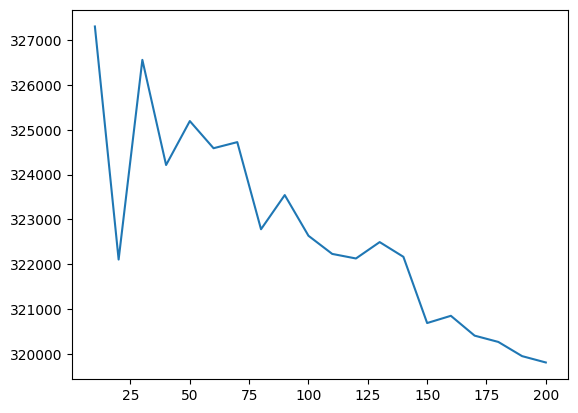

In [37]:
import seaborn as sns
from matplotlib import pyplot as plt

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
plt.plot(df_scores.n_estimators, df_scores.rmse) 
# plt.legend()

## Appendix

In [20]:
# df.zip.nunique() # 834 - too many for grouping...

In [21]:
# df.address.nunique() # 919 - too many as well...

In [22]:
# idea - we need to extract city districts (wijk in Dutch) based on the zip/street address
# collect a sentiment score for each district in range 1-10 using LLM - good or bad for living
# and add it as columns to our dataset - district and sentiment - as realtors often say - location, location, location...

# I decided to drop GPS lat long columns - not to mess up with Google maps API for simplicity
# and used Amsterdam district names from here:
# https://data.europa.eu/data/datasets/22433-postcode-buurt-wijk?locale=da

# idea 2 - in Amsterdam city district - wijk consists of subdistricts - buurt
# which consists of PC4 post codes (first 4 digits of zip column in our dataset)
# I will drop the street address for now and map buurt and wijk from downloaded CSV to PC4

In [23]:
# small explanation how Dutch postal addresses are organised
# The PC4 (first four digits of zip code) identifies a broad area within a city — 
# this can be mapped to neighbourhood or district statistically.
# The PC6 (full 6 characters of zip code, including letters) often maps to one side 
# of a street, or even a cluster of house numbers.
# The letter pair (e.g., CR in zip = '1091 CR') is simply a unique subdivision to make post sorting precise.

# Example:
# full zip  = 1091 CR
# street address: Blasiusstraat 8 2, Amsterdam
# Neighbourhood (Buurt): Weesperzijde
# District (Wijk): Oud-Oost
# Part of the city (Stadsdeel): Amsterdam-Oost

# so the naming hierachy is postcode → buurt → wijk


# prepare our df zip code col for mapping
# df['pc4'] = df.zip.str.split().str[0]
# df['PC6'] = df.zip.str.replace(' ', '')
# df.head(1)

In [24]:
# df.pc4.nunique() # 70 - much better for grouping

In [25]:
# STEP 2 - download district and area codes - buurt and wijk - from national statistics bureau:
# https://www.cbs.nl/nl-nl/maatwerk/2023/35/buurt-wijk-en-gemeente-2023-voor-postcode-huisnummer

# mapping = pd.read_csv('pc6hnr20230801_gwb.csv', delimiter=';')
# mapping.head(1)

In [26]:
# merge dataframes

# df = df.merge(mapping, on='PC6')
# df